In [1]:
from phimal_utilities.data import Dataset_2D
from phimal_utilities.data.diffusion import AdvectionDiffusionGaussian2D

import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
dataset = Dataset_2D(AdvectionDiffusionGaussian2D, D=1.0, x0=[0.0, 0.0], sigma=0.5, v=[0.5, 0.5])

In [3]:
# Making grid
x = np.linspace(-4, 4, 100)
t = np.linspace(0.0, 2.0, 25)
x_grid, y_grid, t_grid = np.meshgrid(x, x, t, indexing='ij')

X = np.concatenate([x_grid.reshape(-1, 1), y_grid.reshape(-1, 1)], axis=1)

In [4]:
u = dataset.generate_solution(X, t_grid.reshape(-1, 1))

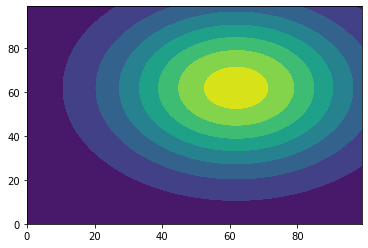

In [5]:
frame = 24
plt.contourf(u.reshape(x_grid.shape)[:, :, frame])

In [6]:
t_deriv=dataset.time_deriv(X,t_grid.reshape(-1,1)).reshape(x_grid.shape)

In [7]:
library_deriv = dataset.library(X,t_grid.reshape(-1,1)).reshape(x_grid.shape[0],x_grid.shape[1],x_grid.shape[2],12)

ValueError: cannot reshape array of size 1500000 into shape (100,100,25,12)

In [8]:
x_grid.shape

(100, 100, 25)

In [9]:
t_deriv.shape

(100, 100, 25)

In [10]:
plt.contourf(library_deriv[:,:,2,2])


NameError: name 'library_deriv' is not defined

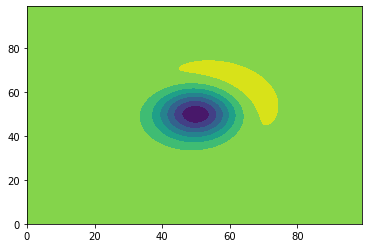

In [11]:
plt.contourf(t_deriv[:,:,3])


In [12]:
from DeePyMoD_SBL.deepymod_torch.library_functions import library_2Din_1Dout
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepMod

import time
from DeePyMoD_SBL.deepymod_torch.output import Tensorboard, progress
from DeePyMoD_SBL.deepymod_torch.losses import reg_loss, mse_loss, l1_loss
from DeePyMoD_SBL.deepymod_torch.sparsity import scaling, threshold
from numpy import pi


/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [13]:
# Defining training function
def train(model, data, target, optimizer, max_iterations, loss_func_args, log_dir=None):
    start_time = time.time()
    number_of_terms = [coeff_vec.shape[0] for coeff_vec in model(data)[3]]
    board = Tensorboard(number_of_terms, log_dir)
    
    # Training
    print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |')
    for iteration in torch.arange(0, max_iterations + 1):
        # Calculating prediction and library and scaling
        prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(data)
        coeff_vector_scaled_list = scaling(coeff_vector_list, sparse_theta_list, time_deriv_list) 
        
        # Calculating loss
        loss_mse = mse_loss(prediction, target)
        loss_reg = reg_loss(time_deriv_list, sparse_theta_list, coeff_vector_list)
        loss = torch.sum(loss_mse) + torch.sum(loss_reg)
        
        # Writing
        if iteration % 100 == 0:
            # Write progress to command line
            progress(iteration, start_time, max_iterations, loss.item(), torch.sum(loss_mse).item(), torch.sum(loss_reg).item(), torch.sum(loss_reg).item())
            
            lstsq_solution = torch.inverse(theta.T @ theta) @ theta.T @ time_deriv_list[0]
            
            # Calculate error for theta
            theta_true = loss_func_args['library']
            dt_true = loss_func_args['time_deriv']
            mae_library = torch.mean(torch.abs(theta - theta_true), dim=0)
            mae_dt = torch.mean(torch.abs(dt_true - time_deriv_list[0]), dim=0)
            
            # Write to tensorboard
            board.write(iteration, loss, loss_mse, loss_reg, loss_reg, coeff_vector_list, coeff_vector_scaled_list, lstsq_solution=lstsq_solution.squeeze(), mae_library=mae_library, mae_time_deriv=mae_dt)

        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    board.close()


In [14]:
import numpy as np
import torch

# Settings and parameters
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [49]:
config = {'n_in': 3, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_2Din_1Dout, 'library_args':{'poly_order':1, 'diff_order': 2}}
n_runs = 5

In [50]:
dataset = Dataset_2D(AdvectionDiffusionGaussian2D, D=2.0, x0=[0.0, 0.0], sigma=0.5, v=[1.0, 1.0])

In [51]:
x_grid.shape

(100, 100, 25)

In [52]:
 X_train, y_train, rand_idx = dataset.create_dataset(X,t_grid.reshape(-1,1), n_samples=1000, noise=0.1, random=True, return_idx=True)

In [53]:
X_train.shape

torch.Size([1000, 3])

In [48]:
theta = dataset.library(X,t_grid.reshape(-1,1), poly_order=1)[rand_idx, :]
dt = dataset.time_deriv(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1))[rand_idx, :]

In [41]:
model = DeepMod(**config)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True)

In [42]:
X_train.shape

torch.Size([1000, 3])

In [43]:
train(model, X_train, y_train, optimizer, 20000, loss_func_args={'library':torch.tensor(theta) ,'time_deriv': torch.tensor(dt)}, log_dir = None)

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |
      20000    100.00%               0s   1.34e-04   1.19e-04   1.49e-05   1.49e-05 